In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import image
import cartopy
import cartopy.crs as ccrs
import pandas as pd
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

In [10]:
case = "fanv3_debugging"
path = "/glade/scratch/jinmuluo/archive/one_year/lnd/hist/" 
h = 'h2'
start_date = date(2000, 1, 1)
end_date = date(2000, 12, 1)
delta = end_date - start_date
fieldsh3 = ['NOx_NITRIFY_GRZ', 'N2O_NITRIFY_GRZ', 'NOx_DENITRIFY_GRZ', 'N2O_DENITRIFY_GRZ', 'N2_DENITRIFY_GRZ', 
            'NOx_NITRIFY_APP', 'N2O_NITRIFY_APP', 'NOx_DENITRIFY_APP', 'N2O_DENITRIFY_APP', 'N2_DENITRIFY_APP',
            'NOx_NITRIFY_FERT', 'N2O_NITRIFY_FERT', 'NOx_DENITRIFY_FERT', 'N2O_DENITRIFY_FERT', 'N2_DENITRIFY_FERT',
            'NOx_NITRIFY_OTHERFERT', 'N2O_NITRIFY_OTHERFERT', 'NOx_DENITRIFY_OTHERFERT', 'N2O_DENITRIFY_OTHERFERT', 
            'N2_DENITRIFY_OTHERFERT', 'area']
fieldsh2 = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "area"]
fieldsh1 = ["NITRITE_G1", "NITRITE_G2", "NITRITE_G3", "NITRITE_S0", "NITRITE_S1", "NITRITE_S2",
            "NITRITE_S3", "NITRITE_F1", "NITRITE_F2",  "NITRITE_F3",  "NITRITE_F4",'area']
fieldsh0 = ["GPP", "FERT_NO3_TO_SOIL", "MANURE_NO3_TO_SOIL", "MANURE_NITRITE_RUNOFF", 'FERT_NITRITE_RUNOFF', 
            "FERT_NITRITE_TO_SOIL", "MANURE_NITRITE_TO_SOIL", 'area']
fanCLM = []
for i in range(delta.days//30 + 1):
    month = start_date + relativedelta(months=i)
    month = month.strftime('%Y-%m')
    fanCLM.append(path + case + ".clm2." + h + "." + month +".nc")
print(len(fanCLM), fanCLM[-1])

12 /glade/scratch/jinmuluo/archive/one_year/lnd/hist/fanv3_debugging.clm2.h2.2000-12.nc


In [11]:
def choose_field(h):
    if h == "h0":
        result = fieldsh0
    elif h == "h1":
        result = fieldsh1
    elif h == "h2":
        result = fieldsh2
    elif h == "h3":
        result = fieldsh3
    elif h == "h4":
        result = fieldsh4
    else:
        exit("please check your hist name!")
    return result

def preprocess(ds, fields = choose_field(h)):
    return(ds[fields])

def fix_time(ds):  
    date0 = ds['time'][0].values
    date1 = ds['time'][-1].values
    # ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')
    ds['time'] = pd.date_range(str(date0),str(date1),freq='MS') 
    
    return ds

dsCLM = fix_time(xr.open_mfdataset(fanCLM, decode_times=True, preprocess=preprocess))
dsCLM

<xarray.Dataset>
Dimensions:              (time: 12, lat: 96, lon: 144)
Coordinates:
  * time                 (time) datetime64[ns] 2000-02-01 ... 2001-01-01
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Data variables:
    N2O_DENITRIFY_TOTAL  (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    N2O_NITRIFY_TOTAL    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    NOx_DENITRIFY_TOTAL  (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    NOx_NITRIFY_TOTAL    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    area                 (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 02/16/23 09:06:14
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./fanv3_debugging.clm2.h0.2000-01.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

In [12]:
def sp_plot(ds, field, coords, show=False):
    sp = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
    if show:
        sp[field].plot(x='time')
        plt.show()
    return sp

In [13]:
def tot_plot(ds, field, show=False, savefig=False):
    # calculate global total emission
    total = ds[field] * ds['area']
    total = total.sum(dim=['lat', 'lon'])*0.36*24*30
    total.attrs['units'] = 'Gg N/month'
    if show:
        total.plot(x='time')
        plt.title(field)
        plt.ylabel(total.attrs['units'])
        plt.show()
        if savefig:
            plt.savefig(field, dpi=150)
    return total

In [14]:
def regional_plot(ds, field, coords, show=False):
    x = slice(coords['lower_lat'], coords['upper_lat'])
    y = slice(coords['west_lon'], coords['east_lon'])
    # gN/m2/s to TonN/s
    rp = (ds[field].sel(lat=x, lon=y) * ds['area'].sel(lat=x, lon=y)).sum(dim=['lat', 'lon'])
    rp.attrs['units'] = 'Tons N/sec'
    if show:
        rp.plot(x='time')
        plt.title(field)
        plt.ylabel(rp.attrs['units'])
        plt.show()
    return rp

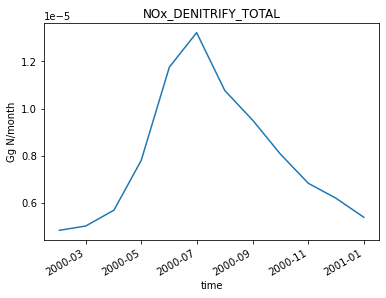

<xarray.DataArray (time: 12)>
dask.array<mul, shape=(12,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-02-01 2000-03-01 ... 2001-01-01
Attributes:
    units:    Gg N/month

In [23]:
tot_plot(ds=dsCLM, field=choose_field(h)[2], show=True, savefig=False)

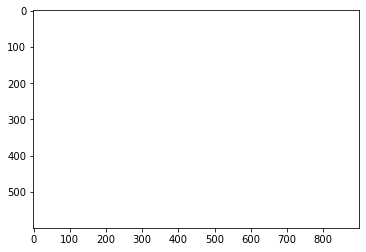

In [12]:
im = image.imread("N2O_NITRIFY_TOTAL.png")
plt.imshow(im)
plt.show()

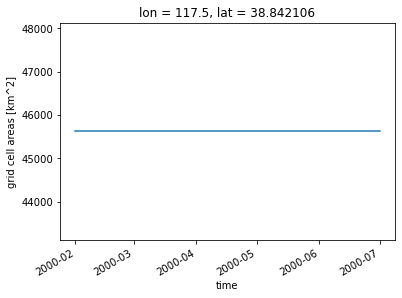

In [9]:
coordinates = [39.24, 116.25]
sp = sp_plot(ds=dsCLM, field=choose_field(h)[4], coords=coordinates, show=True)

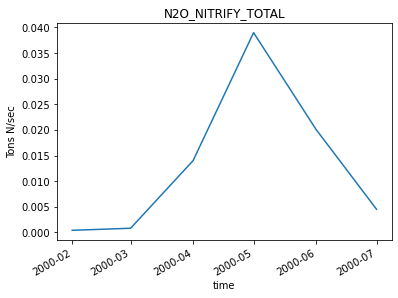

<xarray.DataArray (time: 6)>
dask.array<sum-aggregate, shape=(6,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-02-01 2000-03-01 ... 2000-07-01
Attributes:
    units:    Tons N/sec

In [10]:
coordinates = {'upper_lat':45.50, 'lower_lat':25.35, 'west_lon': 100.00, 'east_lon':130.00}
regional_plot(ds=dsCLM, field=choose_field(h)[1], coords=coordinates, show=True)